# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist
from networks import EncodingModule 

import pdb

## Setting up network and loading weights

In [2]:
# model_name = "mono_640x192"

# download_model_if_doesnt_exist(model_name)
# encoder_path = os.path.join("models", model_name, "encoder.pth")
# depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# # LOADING PRETRAINED MODEL
# encoder = networks.ResnetEncoder(18, False)
# depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

# loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
# filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
# encoder.load_state_dict(filtered_dict_enc)

# loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
# depth_decoder.load_state_dict(loaded_dict)

# encoder.eval()
# depth_decoder.eval();

In [2]:

encoder = networks.EncodingModule(18, {'img':False, 'lidar':False}, 'models/mono_640x192/encoder.pth')

new_enc_path = '/home/divatekodand/tmp/depth_supervision/models/weights_18/encoder.pth'
encoder_dict = torch.load(new_enc_path, map_location='cpu')
model_dict = encoder.state_dict()
encoder.load_state_dict({k: v for k, v in encoder_dict.items() if k in model_dict})


encoder.eval()

depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))
depth_decoder_path = '/home/divatekodand/tmp/depth_supervision/models/weights_18/depth.pth'
loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)
depth_decoder.eval()

Encoding Module Expected Image height -  192
Encoding Module Expected Image width -  640


DepthDecoder(
  (decoder): ModuleList(
    (0): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (1): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (2): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (3): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (4): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv

## Loading the test image and preprocessing

In [25]:
# image_path = "assets/006656.png"
image_path = "../data_sample/000039.png"
input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = encoder_dict['height']
feed_width = encoder_dict['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

In [5]:
print(feed_width,  " ", feed_height)

640   192


## Prediction using the PyTorch model

--Return--
> <ipython-input-50-96a5b5099ff9>(10)<module>()->None
-> pdb.set_trace()
(Pdb) c
torch.Size([1, 64, 96, 320])
torch.Size([1, 64, 48, 160])
torch.Size([1, 128, 24, 80])
torch.Size([1, 256, 12, 40])
torch.Size([1, 512, 6, 20])


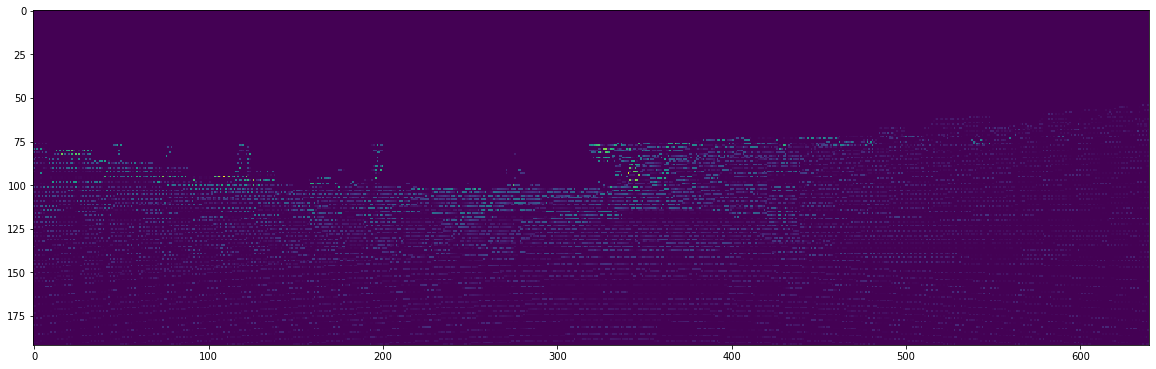

In [50]:
import scipy.io as sio


tensors_file = './tensors.mat'
tensor_dict = sio.loadmat(tensors_file)
input_color = tensor_dict["input_color"]
input_depth = tensor_dict["input_depth"]
icolor = torch.tensor(input_color, dtype=torch.float32)
idepth = torch.tensor(input_depth, dtype=torch.float32)
pdb.set_trace()
with torch.no_grad():
    features = encoder(icolor[0:1, :, :, :], idepth[0:1, :,:,:])
    for f in features:
        print(f.shape)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

plt.figure(figsize=(20, 20))
plt.imshow(idepth[0,0,:,:].numpy())

In [26]:
import pdb
# import scipy.misc.imresize as imresize
import cv2

h = 192
w = 640
c = 3

pdb.set_trace()
# lidar_image = smic.imresize(lidar_image, (h,w,c))
#interpolation = cv2.INTER_CUBIC
lidar_image = cv2.resize(kitti_lidar, (w, h), interpolation = cv2.INTER_CUBIC)
lidar_tensor = torch.tensor(lidar_image, dtype=torch.float32)
lidar_tensor.permute(2,0,1)
lidar_tensor = lidar_tensor.reshape(-1, c, h, w)

# input_image = smic.imresize(input_image, (h,w), interpolation = cv2.INTER_CUBIC)
input_image = cv2.resize(kitti_image, (w,h), interpolation = cv2.INTER_CUBIC)
image_tensor = torch.tensor(input_image, dtype=torch.float32)
image_tensor.permute(2,0,1)
image_tensor = image_tensor.reshape(-1, c, h, w)



pdb.set_trace()
with torch.no_grad():
    features = encoder(image_tensor, lidar_tensor[:, 0:1,:,:])
    for f in features:
        print(f.shape)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

--Return--
> <ipython-input-26-288b5d738415>(9)<module>()->None
-> pdb.set_trace()
(Pdb) c
--Return--
> <ipython-input-26-288b5d738415>(25)<module>()->None
-> pdb.set_trace()
(Pdb) c
torch.Size([1, 64, 96, 320])
torch.Size([1, 64, 48, 160])
torch.Size([1, 128, 24, 80])
torch.Size([1, 256, 12, 40])
torch.Size([1, 512, 6, 20])


## Plotting

torch.Size([1, 1, 375, 1242])
torch.Size([1, 1, 192, 640])
368640
(192, 640, 3)
disparity -  (375, 1242)


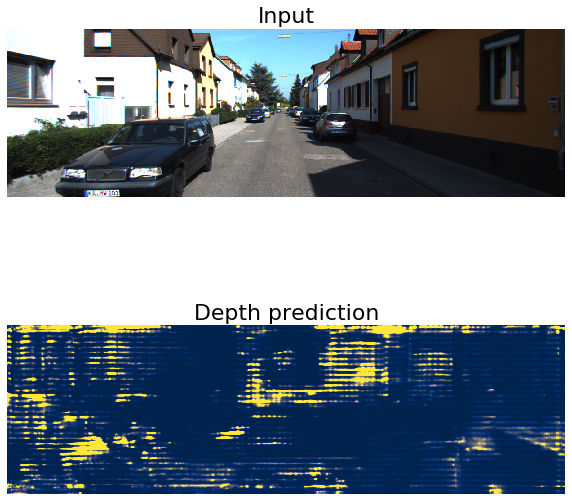

In [27]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)
print(disp_resized.size())
print(disp.size())
print(input_image.size)
# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(kitti_image)
print(input_image.shape)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='cividis', vmax=vmax)
print("disparity - ", disp_resized_np.shape)
plt.title("Depth prediction", fontsize=22)
plt.axis('off');

## Projections

In [22]:
def lidar_to_camera(x, y, z):
    MATRIX_T_VELO_2_CAM = np.array ([
        [7.49916597e-03, -9.99971248e-01, -8.65110297e-04, -6.71807577e-03],
        [1.18652889e-02, 9.54520517e-04, -9.99910318e-01, -7.33152811e-02],
        [9.99882833e-01, 7.49141178e-03, 1.18719929e-02, -2.78557062e-01],
        [0, 0, 0, 1]
    ])
    
    MATRIX_R_RECT_0 = np.array(([
        [0.99992475, 0.00975976, -0.00734152, 0],
        [-0.0097913, 0.99994262, -0.00430371, 0],
        [0.00729911, 0.0043753, 0.99996319, 0],
        [0, 0, 0, 1]
    ]))
    
    P_MAT =  ([[719.787081,    0.,            608.463003, 44.9538775],
                      [0.,            719.787081,    174.545111, 0.1066855],
                      [0.,            0.,            1.,         3.0106472e-03],
                      [0.,            0.,            0.,         0]])
    
    p = np.array([x, y, z, 1])
    p = np.matmul(MATRIX_T_VELO_2_CAM, p)
    p = np.matmul(MATRIX_R_RECT_0, p)
    p = np.matmul(P_MAT, p)
    p = p[0:3]
    return p


def kitti_lidar_to_camera(points):
    if points.shape[1] == 4:
        points = points[:, 0:3]
    num_points = points.shape[0]
    camera_points = np.zeros((num_points, 3))
    image_points = np.zeros((num_points, 3))
    for i in range(num_points):
        p = points[i, :]
        p = lidar_to_camera(p[0], p[1], p[2])
        camera_points[i, :] = p
        image_points[i,:] = p / p[2]
        
    return camera_points, image_points
        

def kitti_camera_to_lidar(disparity_map):
    MATRIX_P2 = np.array([[719.787081,    0.,            608.463003, 44.9538775],
                          [0.,            719.787081,    174.545111, 0.1066855],
                          [0.,            0.,            1.,         3.0106472e-03],
                          [0.,            0.,            0.,         0]])
    #print(MATRIX_P2.shape)
    int_mat = MATRIX_P2[0:3,0:3]
    #print(int_mat)
    #print(disp_resized_np.shape)
    points = []
    for i in range(disp_resized_np.shape[0]):
        for j in range(disp_resized_np.shape[1]):
            pt = disp_resized_np[i,j]*np.dot(np.linalg.inv(int_mat), np.array([i,j,1]))
            points.append(pt)
    
    return np.array(points)

In [23]:
import numpy as np
import scipy.io as sio
from math import floor

image_path = "../data_sample/000039.png"
lidar_path = "../data_sample/000039_pc_crop.mat"

image_path2 = "../data_sample/006656/006656.png"
lidar_path2 = "../data_sample/006656/lidar_cropped.mat"

kitti_image = np.array(pil.open(image_path).convert('RGB'))

pc = sio.loadmat(lidar_path)['val']
cpoints, ipoints = kitti_lidar_to_camera(pc)

(16470, 3)
1239.2326933914726
373.82629810261
1.0
0.3228831452651088
106.7708899550903
1.0
(375, 1242, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


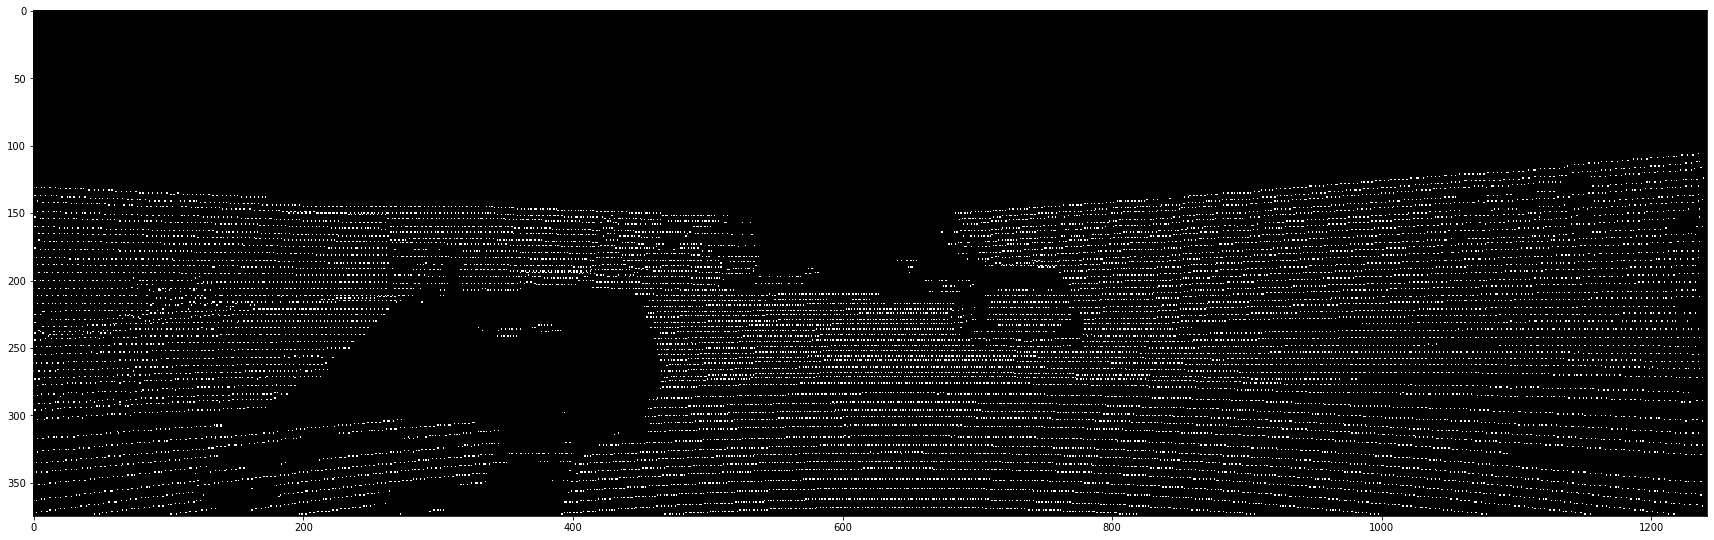

In [24]:

print(cpoints.shape)
# for cpoint in cpoints:
#     print(cpoint)
print(np.max(ipoints[:, 0]))
print(np.max(ipoints[:, 1]))
print(np.max(ipoints[:, 2]))
print(np.min(ipoints[:, 0]))
print(np.min(ipoints[:, 1]))
print(np.min(ipoints[:, 2]))

print(kitti_image.shape)

kitti_lidar = np.zeros(tuple(kitti_image.shape))

for i in range(ipoints.shape[0]):
    y = floor(ipoints[i, 1])
    x = floor(ipoints[i, 0])
    if x < kitti_lidar.shape[1] and y < kitti_lidar.shape[0]:
        kitti_lidar[y, x, :] = floor(cpoints[i, 2])

plt.figure(figsize=(30, 30))    
plt.imshow(kitti_lidar)

In [19]:
print(np.max(cpoints[:,2]))
print(np.min(cpoints[:,2]))

53.45050490426961
5.502838585927604


In [7]:
# input_image = np.random(())
MATRIX_P2 = np.array([[719.787081,    0.,            608.463003, 44.9538775],
                      [0.,            719.787081,    174.545111, 0.1066855],
                      [0.,            0.,            1.,         3.0106472e-03],
                      [0.,            0.,            0.,         0]])
print(MATRIX_P2.shape)
int_mat = MATRIX_P2[0:3,0:3]
print(int_mat)
print(disp_resized_np.shape)
points = []
for i in range(disp_resized_np.shape[0]):
    for j in range(disp_resized_np.shape[1]):
        pt = disp_resized_np[i,j]*np.dot(np.linalg.inv(int_mat), np.array([i,j,1]))
        points.append(pt)



(4, 4)
[[719.787081   0.       608.463003]
 [  0.       719.787081 174.545111]
 [  0.         0.         1.      ]]
(375, 1242)


In [8]:
P = np.array(points)
P.shape

(465750, 3)

In [9]:
import scipy.io as sio
P = np.array(points)
sio.savemat('../data_sample/000039_depth.mat',{'points':P})

In [47]:
import pptk
P = np.array(points)
print(P.shape)
v = pptk.viewer(P) 
v.set(point_size=0.01)

(452880, 3)


KeyboardInterrupt: 